In [1]:
#basic package
import json
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import shutil
import time
import datetime as dt
import itertools
import re
import math
import random
from sklearn.manifold import Isomap

#0-1 normalisation
from sklearn import preprocessing
#modelling
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler

#PCA
import plotly.express as px
from sklearn.decomposition import PCA

#plot
import cv2
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
import seaborn as sns

In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import cleaning_processing, HenDailyVariable_Origins, plot_scikit_lda, explained_var, sampen, kmeans_clustering,\
time_series_henColumn_tsRow
import config_origins as config

C:\Users\camil\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [3]:
#initialise parameters
path_extracted_data = config.path_extracted_data
path_initial_data = config.path_initial_data
id_run = config.id_run
pal_ = config.pal_
dico_matching = config.dico_matching
dico_zone_order = config.dico_zone_order
dico_night_hour = config.dico_night_hour
dico_garden_opening_hour = config.dico_garden_opening_hour
path_extracted_data_visual_cons = os.path.join(path_extracted_data,'visual','IndividualConsistency')
#create a director if not existing
if not os.path.exists(path_extracted_data_visual_cons):
    os.makedirs(path_extracted_data_visual_cons)

path_extracted_data_visual_treatmentclass = os.path.join(path_extracted_data,'visual','Treatment&Classs')
#create a director if not existing
if not os.path.exists(path_extracted_data_visual_treatmentclass):
    os.makedirs(path_extracted_data_visual_treatmentclass)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Download data

In [6]:
#for being more reproductible, we open the file that was saved from cleaning
df_daily = pd.read_csv(os.path.join(path_extracted_data, 'daily_ALL_Variable_Tranformed.csv'), sep=';',
                     parse_dates=['level'], dayfirst=True) 
df_daily['in_WG_15mnAfterOpening'] = df_daily['in_WG_15mnAfterOpening'].map(lambda x: float(x))
df_daily['Consistent_Night_Zone5Days'] = df_daily['Consistent_Night_Zone5Days'].map(lambda x: float(x))
print(df_daily.shape)
df_daily.head(3)

(27214, 198)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,level,duration_1_Zone,duration_2_Zone,duration_3_Zone,duration_4_Zone,duration_5_Zone,verification_daily_total_duration,dur_values,dur_values_normalized,...,clustering_WG,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,clustering_ALL
0,hen_1,2020-09-30,0.0,18886.0,3488.0,518.0,5908.0,28800.0,"[0.0, 18886.0, 3488.0, 518.0, 5908.0]","[0.0, 0.6557638888888889, 0.12111111111111111,...",...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,hen_1,2020-10-01,0.0,9310.0,5636.0,0.0,17454.0,32400.0,"[0.0, 9310.0, 5636.0, 0.0, 17454.0]","[0.0, 0.2873456790123457, 0.17395061728395061,...",...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,hen_1,2020-10-02,0.0,0.0,551.0,0.0,31849.0,32400.0,"[0.0, 0.0, 551.0, 0.0, 31849.0]","[0.0, 0.0, 0.017006172839506173, 0.0, 0.982993...",...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
df_FB = pd.read_csv(os.path.join(path_extracted_data, id_run+'df_FOCALBIRDS.csv'), sep=';') 
print(df_FB.shape)
df_FB.head(3)

(211, 11)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,PenID,CLASS,R-Pen,InitialStartDate,29-09 weight,10-12 juin weight,weight 23-11-2020,weight 04-01-2021,weight 01-02-21,Treatment
0,hen_1,9,EPI,1.0,10.06.2020,1134.0,57.0,1696.5,1787.8,1800.9,OFH
1,hen_10,11,LEXP,1.0,10.06.2020,1070.0,70.4,1488.3,1628.4,1602.1,OFH
2,hen_100,5,EPI,3.0,10.06.2020,1182.0,80.5,1642.5,NaN,NaN,OFH


In [26]:
print(df_daily.shape)
df_daily = df_daily[df_daily['DOA']>=150]
print(df_daily.shape)

(22867, 183)
(18138, 183)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [54]:
li_var = ['duration_5_Zone','nbr_stays_1_Zone','nbr_stays_4_Zone',
          'sucessIntrusion_9','in_WG_15mnAfterOpening','Max_duration_WG','night_Total_number_transition',
          'vertical_travel_distance']

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [55]:
#keep hens that have more than "min_nbr_days" days
df = df_daily[li_var+['HenID','level']].copy()
print(df.shape)
df = df[~df.isnull().any(axis=1)]
print(df.shape)

(18138, 10)
(14084, 10)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [56]:
#select hens
min_nbr_days = 80
df_ = df.groupby(['HenID'])['duration_5_Zone'].count().reset_index()
df_['has_more_'+str(min_nbr_days)+'days'] = df_['duration_5_Zone'].map(lambda x: x>min_nbr_days)
display(df_.head(3))
li_hen2keep = df_[df_['has_more_'+str(min_nbr_days)+'days']]['HenID'].unique()
print(df[df['HenID'].isin(li_hen2keep)].shape, len(li_hen2keep))
df = df[df['HenID'].isin(li_hen2keep)].copy()
print(df.shape)
df.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,duration_5_Zone,has_more_80days
0,hen_1,83,True
1,hen_10,90,True
2,hen_100,17,False


(12145, 10) 136
(12145, 10)


,duration_5_Zone,nbr_stays_1_Zone,nbr_stays_4_Zone,sucessIntrusion_9,in_WG_15mnAfterOpening,Max_duration_WG,night_Total_number_transition,vertical_travel_distance,HenID,level
32,3539.0,11.0,12.0,0.125000,0.0,1086.0,0.0,53.0,hen_131,2020-10-31
33,1903.0,8.0,12.0,0.142857,1.0,785.0,0.0,68.0,hen_131,2020-11-01
34,2673.0,5.0,8.0,0.250000,0.0,521.0,0.0,64.0,hen_131,2020-11-02


In [57]:
#compute sample entropy for each va, for each hen
#TODO care about consecutives days
df_hen = df.sort_values(['level']).groupby(['HenID'])[li_var].agg(lambda x: sampen(x)).reset_index()
print(df_hen.shape)
df_hen.head(2)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\camil\Desktop\animals_code\PhD\UTILS.py:2885: RuntimeWarning: divide by zero encountered in log
  return -np.log(A/B)


(136, 9)


,HenID,duration_5_Zone,nbr_stays_1_Zone,nbr_stays_4_Zone,sucessIntrusion_9,in_WG_15mnAfterOpening,Max_duration_WG,night_Total_number_transition,vertical_travel_distance
0,hen_1,0.988217,1.812379,1.909543,0.747470,0.700948,1.782457,0.095168,2.374906
1,hen_10,0.702252,0.879813,1.914161,1.297945,0.060129,1.110447,1.183770,1.632695


In [58]:
df_hen = df_hen.replace(np.inf, np.nan)
print(df_hen.shape)
df_hen = df_hen[~df_hen.isnull().any(axis=1)]
print(df_hen.shape)

(136, 9)
(131, 9)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [59]:
#clustering
li_2keep = ['HenID']
li_ = range(2,10)
r, center_ = kmeans_clustering(df=df_hen, range_n_clusters=li_, drop_col_list=li_2keep)
if len(r)!=df_hen.shape[0]:
    print('ERROR')
    sys.exit()
df_hen['clustering_consistency'] = r
print(df_hen.shape)
df_hen.head(3)

For n_clusters = 2 The average silhouette_score is : 0.2937055945856042
For n_clusters = 3 The average silhouette_score is : 0.2262701811064756
For n_clusters = 4 The average silhouette_score is : 0.1754767937956275
For n_clusters = 5 The average silhouette_score is : 0.17025342944555918


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


For n_clusters = 6 The average silhouette_score is : 0.1567193433615688
For n_clusters = 7 The average silhouette_score is : 0.15273014319187203
For n_clusters = 8 The average silhouette_score is : 0.16012393043217804
For n_clusters = 9 The average silhouette_score is : 0.16393933377479636
Please let me know the numbers of clusters you want to search for 3
(131, 8)
(131, 10)


,HenID,duration_5_Zone,nbr_stays_1_Zone,nbr_stays_4_Zone,sucessIntrusion_9,in_WG_15mnAfterOpening,Max_duration_WG,night_Total_number_transition,vertical_travel_distance,clustering_consistency
0,hen_1,0.988217,1.812379,1.909543,0.747470,0.700948,1.782457,0.095168,2.374906,1
1,hen_10,0.702252,0.879813,1.914161,1.297945,0.060129,1.110447,1.183770,1.632695,0
2,hen_101,0.538997,1.148284,0.951832,2.045208,0.370819,0.825907,0.445547,1.446919,0


In [60]:
#### one table with mean for each variable within each clusters
li_df = []#
for k in df_hen['clustering_consistency'].unique():
    df0 = df_hen[df_hen['clustering_consistency']==k][li_var]
    li_df.append(df0.mean())
df_m = pd.concat(li_df,axis=1)
df_m.to_csv(os.path.join(path_extracted_data_visual_cons, 'clusters_properties.csv'))
print(df_m.shape)
df_m

(8, 3)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0,1,2
duration_5_Zone,1.501809,1.056574,1.682456
nbr_stays_1_Zone,1.792496,0.508854,0.592509
nbr_stays_4_Zone,2.066522,1.280535,2.291022
sucessIntrusion_9,1.457270,1.061503,1.529070
in_WG_15mnAfterOpening,0.350609,0.099446,0.089339
Max_duration_WG,1.647864,0.466887,0.574901
night_Total_number_transition,0.457571,0.498309,0.400325
vertical_travel_distance,1.926734,1.588452,1.909748


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


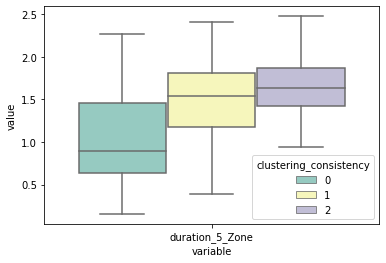

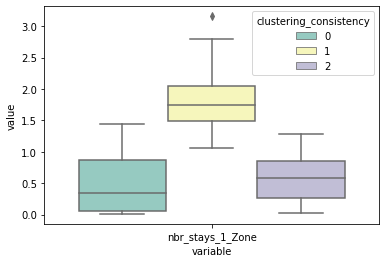

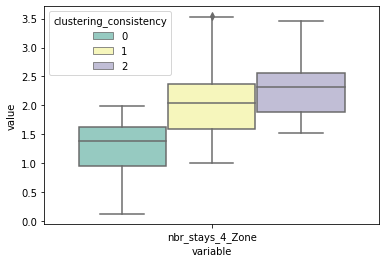

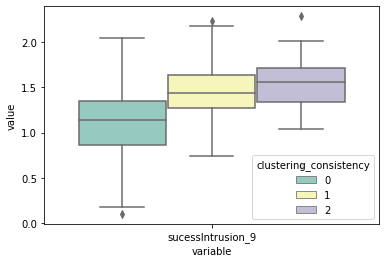

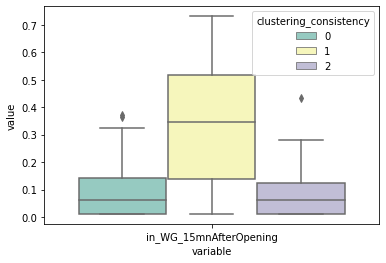

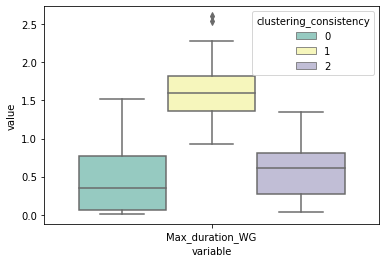

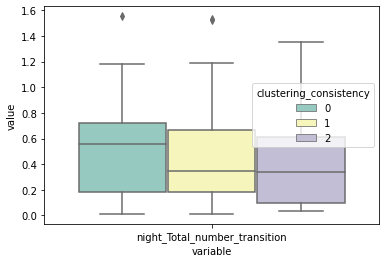

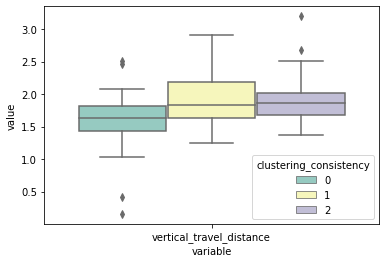

In [61]:
#### plot boxplot for each x variable
for x in li_var:
    df_plt = pd.melt(df_hen, id_vars=['clustering_consistency','HenID'], value_vars=x).reset_index(drop=True)
    #display(df_plt.head(3))
    ax = sns.boxplot(x="variable", y="value", hue="clustering_consistency",data=df_plt, palette="Set3")
    plt.savefig(os.path.join(path_extracted_data_visual_cons,'cluster_'+x.replace('/','')+'.png'), bbox_inches='tight')
    plt.show();
#group 1: that are less consistent regarding their litter and winter garden usage
#group 0: specially consistent regarding its duration in top tier, nestbox and successfullintrusion but less regarding the 
#number of transitions at night: less healthy?
#group 2: more inconsistent regarding the duration in top tier, nestbox, successfullintrusion: more healthy?

In [64]:
df_FB.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,PenID,CLASS,R-Pen,InitialStartDate,29-09 weight,10-12 juin weight,weight 23-11-2020,weight 04-01-2021,weight 01-02-21,Treatment
0,hen_1,9,EPI,1.0,10.06.2020,1134.0,57.0,1696.5,1787.8,1800.9,OFH
1,hen_10,11,LEXP,1.0,10.06.2020,1070.0,70.4,1488.3,1628.4,1602.1,OFH
2,hen_100,5,EPI,3.0,10.06.2020,1182.0,80.5,1642.5,NaN,NaN,OFH


In [65]:
df_explore = pd.merge(df_hen, df_FB, on='HenID', how='left')
print(df_explore.shape)
df_explore.head(3)

(131, 20)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,duration_5_Zone,nbr_stays_1_Zone,nbr_stays_4_Zone,sucessIntrusion_9,in_WG_15mnAfterOpening,Max_duration_WG,night_Total_number_transition,vertical_travel_distance,clustering_consistency,PenID,CLASS,R-Pen,InitialStartDate,29-09 weight,10-12 juin weight,weight 23-11-2020,weight 04-01-2021,weight 01-02-21,Treatment
0,hen_1,0.988217,1.812379,1.909543,0.747470,0.700948,1.782457,0.095168,2.374906,1,9,EPI,1.0,10.06.2020,1134.0,57.0,1696.5,1787.8,1800.9,OFH
1,hen_10,0.702252,0.879813,1.914161,1.297945,0.060129,1.110447,1.183770,1.632695,0,11,LEXP,1.0,10.06.2020,1070.0,70.4,1488.3,1628.4,1602.1,OFH
2,hen_101,0.538997,1.148284,0.951832,2.045208,0.370819,0.825907,0.445547,1.446919,0,5,MEXP,3.0,10.06.2020,1082.0,66.0,1625.7,1751.1,1723.4,OFH


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


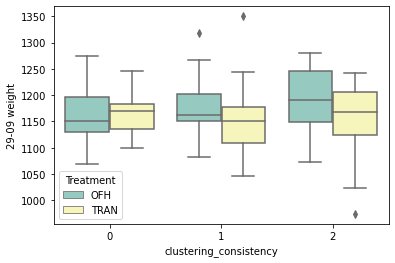

In [78]:
sns.boxplot(x="clustering_consistency", y="29-09 weight", hue='Treatment', data=df_explore, palette="Set3");

In [69]:
#treatment and class
for t in ['Treatment','CLASS']:
    display(df_explore.groupby(t)['clustering_consistency'].value_counts(normalize=True))

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Treatment  clustering_consistency
OFH        1                         0.402985
           2                         0.328358
           0                         0.268657
TRAN       1                         0.546875
           2                         0.250000
           0                         0.203125
Name: clustering_consistency, dtype: float64

CLASS        clustering_consistency
EPI          1                         0.441860
             2                         0.325581
             0                         0.232558
LEXP         1                         0.433333
             0                         0.366667
             2                         0.200000
LEXPLOST     2                         0.428571
             0                         0.285714
             1                         0.285714
MEXP         1                         0.555556
             2                         0.250000
             0                         0.194444
MEXPLOST     2                         1.000000
NewAfterEpi  1                         0.571429
             2                         0.357143
             0                         0.071429
Name: clustering_consistency, dtype: float64

In [152]:
5*2*2 #at maximum

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


20

In [ ]:
1,2,3,4,5

# zone-wise Prediction of binary time series

In [196]:
df = pd.read_csv(os.path.join(path_extracted_data, id_run+'_CLEANEDDATA.csv'), sep=';', parse_dates=['Timestamp', 'date']) 
print(df.shape)
df.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(1104217, 16)


,HenID,PenID,system,Zone,model_prediction,Timestamp,date,next_record_date,duration,previous_record_date,previous_duration,next_zone,previous_zone,previous_previous_zone,correction_is_consecutive_equal_initial_zone,is_WG_open
0,hen_111,pen11,10 - 12,3_Zone,1.0,2020-09-30 00:01:25,2020-09-30,2020-09-30 00:01:38.000,0 days 00:00:13,NaN,NaN,2_Zone,NaN,NaN,False,False
1,hen_111,pen11,10 - 12,2_Zone,1.0,2020-09-30 00:01:38,2020-09-30,2020-09-30 00:14:38.000,0 days 00:13:00,2020-09-30 00:01:25.000,0 days 00:00:13,2_Zone,3_Zone,NaN,False,False
2,hen_147,pen8,8 - 9,5_Zone,1.0,2020-09-30 00:30:49,2020-09-30,2020-09-30 00:33:26.000,0 days 00:02:37,NaN,NaN,5_Zone,NaN,NaN,False,False


In [202]:
#TODO: remove disturbance days!

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [205]:
#remove milliseconds now taht we cleaned the data (ie.e the records with less than 1seconds duration
#sort by timestamp
df.sort_values(['Timestamp'], inplace=True)
#use up to the second level only
df['Timestamp'] = df['Timestamp'].map(lambda x: dt.datetime(x.year,x.month,x.day,x.hour,x.minute, x.second))
#remove the first record
df = df.drop_duplicates(subset=['HenID','Timestamp'], keep='last')
df_init = df.copy()
print('----------------- Create time serie')
df_ts = time_series_henColumn_tsRow(df[df['PenID']=='pen11'], config, col_ts='Zone', ts_with_all_hen_value=False, save=False, hen_time_series=False)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


----------------- Create time serie
in this time series there is 26 hens
The initial starting date in over all is: 2020-09-30 00:01:25, and the ending date will be: 2021-02-09 16:24:45
But note that birds may have different ending and starting date which should be taken into account when computing variables
and after ending the last day at midnight : 2020-09-30 00:01:25, and the ending date will be: 2021-02-09 23:59:59
Total running time: 2.34 mn


In [217]:
min(df['Timestamp'].tolist())

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Timestamp('2020-09-30 00:01:25')

In [209]:
li_z = df['Zone'].unique()
for zone in li_z:
    df_ts_ = df_ts.copy()
    li_ = [i for i in li_z if i!=zone]
    df_ts_ = df_ts_.replace(zone,1)
    df_ts_ = df_ts_.replace(li_,0)
    sys.exit()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


SystemExit: 

C:\Users\camil\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3426: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [211]:
df_ts_.tail(5)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


HenID,Timestamp,hen_10,hen_108,hen_111,hen_112,hen_117,hen_118,hen_14,hen_165,hen_168,...,hen_39,hen_6,hen_7,hen_84,hen_87,hen_9,hen_91,hen_95,hen_99,date
11491110,2021-02-09 23:59:55,1.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2021-02-09
11491111,2021-02-09 23:59:56,1.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2021-02-09
11491112,2021-02-09 23:59:57,1.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2021-02-09
11491113,2021-02-09 23:59:58,1.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2021-02-09
11491114,2021-02-09 23:59:59,1.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2021-02-09


In [219]:
df_ts_['Timestamp'].tolist()[0:5]

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[Timestamp('2020-09-30 00:01:25'),
 Timestamp('2020-09-30 00:01:26'),
 Timestamp('2020-09-30 00:01:27'),
 Timestamp('2020-09-30 00:01:28'),
 Timestamp('2020-09-30 00:01:29')]

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


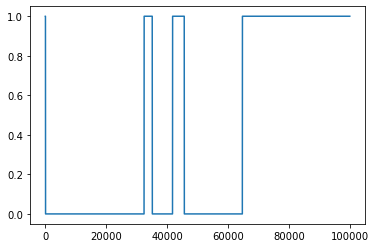

In [224]:
plt.plot(df_ts_[henID].tolist()[0:100000])

## Accelerometer data

In [7]:
li_acc = ['len_MovementCounter_day',
 'MovementCounter_day_amount_nnactivity',
 'MovementCounter_day_max',
 'MovementCounter_day_mean']
df_daily[['level','HenID','list_of_MovementCounter_day']].tail(5)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,level,HenID,list_of_MovementCounter_day
27209,2021-02-24,hen_99,"[9.0, 46.0, 55.0, 82.0, 63.0, 83.0, 72.0, 87.0..."
27210,2021-02-25,hen_99,"[54.0, 77.0, 79.0, 78.0, 81.0, 50.0, 81.0, 69...."
27211,2021-02-26,hen_99,"[3.0, 37.0, 73.0, 76.0, 55.0, 72.0, 74.0, 83.0..."
27212,2021-02-27,hen_99,"[17.0, 67.0, 75.0, 78.0, 72.0, 79.0, 80.0, 56...."
27213,2021-02-28,hen_99,"[14.0, 85.0, 83.0, 79.0, 57.0, 54.0, 46.0, 30...."


In [8]:
#add sum of mvt!!! vertical mvt & total mvt!

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


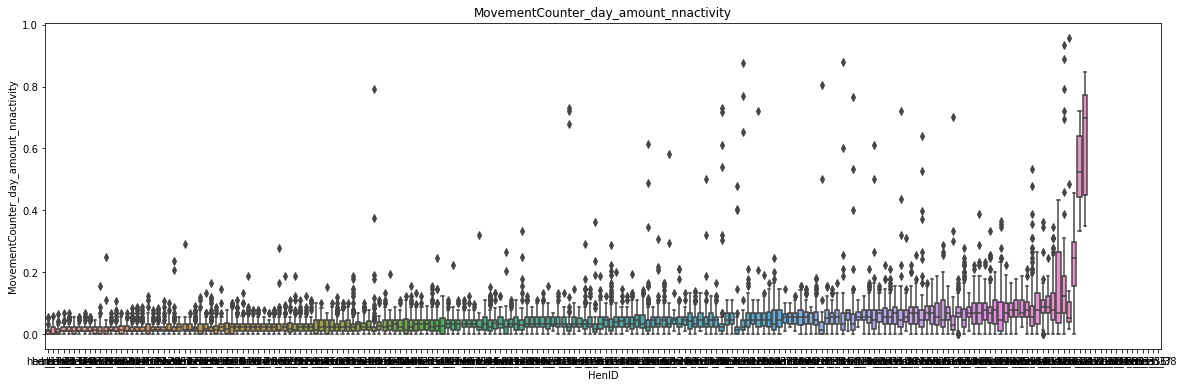

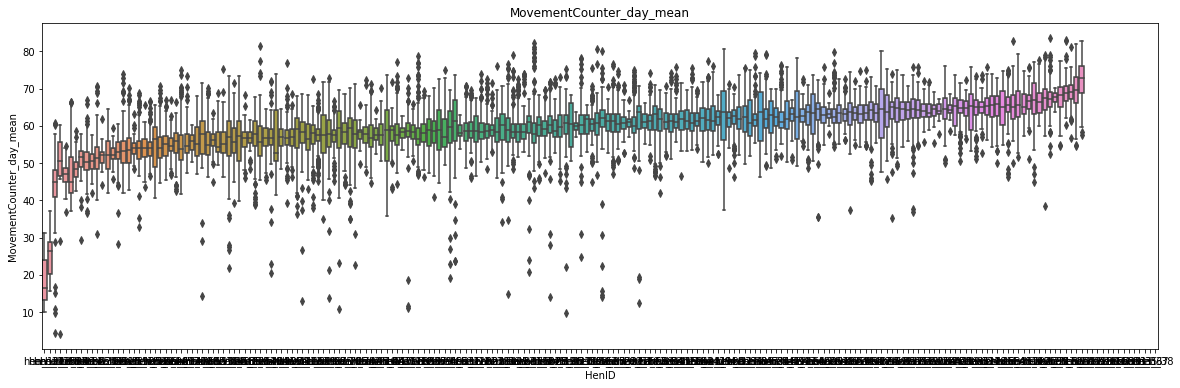

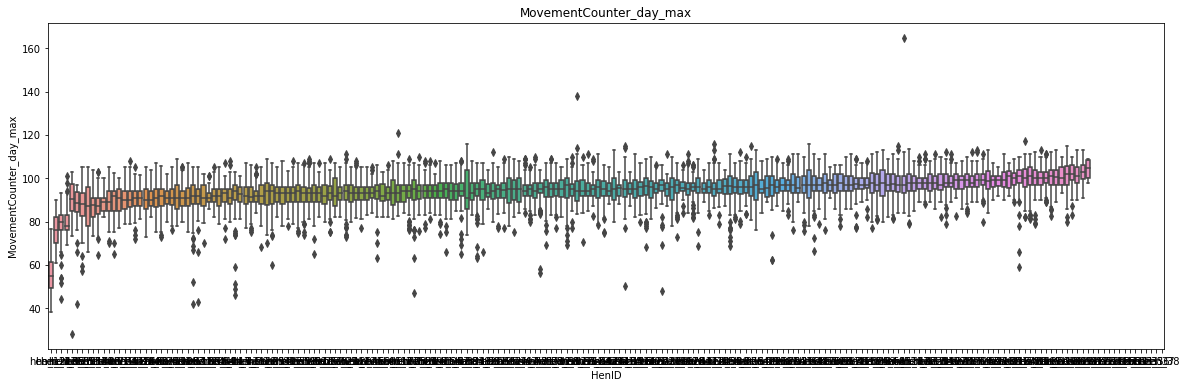

In [9]:
for v in ['MovementCounter_day_amount_nnactivity','MovementCounter_day_mean', 'MovementCounter_day_max']:
    df_order = df_daily.groupby(['HenID'])[v].agg(lambda x: np.mean(x)).reset_index()
    li_hen_order = df_order.sort_values([v])['HenID'].tolist()
    df_plt = df_daily.copy()
    df_plt['hen_order'] = df_plt['HenID'].map(lambda x: li_hen_order.index(x))
    df_plt = df_plt.sort_values(['hen_order'])
    plt.figure(figsize = (20, 6))
    sns.boxplot(x='HenID',y=v,data=df_plt);
    plt.title(v);